# 1. PURPOSE  : 
## Predict  whether clients experience financial distress in the next two years or not       (predict "SeriousDlqin2yrs" = 1 or 0 ) 

# 2. PROCESS :
## DATA EXTRACTION -> DATA CLEANING -> FEATURE ENGINEERING -> TRAIN DATA LEARNING -> MODEL CREATING -> TEST DATA PREDICTION 

# 3. MODEL :
## * Random Forest

In [120]:
import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
from sklearn.datasets import load_boston
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# DATA EXTRACTION

In [121]:
cd /Users/GGV/Desktop/kaggle/give_me_some_credit/

/Users/GGV/Desktop/kaggle/give_me_some_credit


In [122]:
cs_training=pd.read_csv('cs-training.csv')
cs_test=pd.read_csv('cs-test.csv')
sampleEntry=pd.read_csv('sampleEntry.csv')
Data_Dictionary=pd.read_excel('Data_Dictionary.xls')

# DATA CLEANING 

In [123]:
# replace null in MonthlyIncome as MonthlyIncome's average
# replace null in NumberOfDependents as 0

cs_training['MonthlyIncome'] = cs_training['MonthlyIncome'].fillna(cs_training['MonthlyIncome'].mean())
cs_training['NumberOfDependents'] = cs_training['NumberOfDependents'].fillna(0)

cs_training.index= cs_training['Unnamed: 0']
cs_training = cs_training.drop('Unnamed: 0', 1)


In [124]:
# fliter  DebtRatio < 0.9 percentile 
# fliter  RevolvingUtilizationOfUnsecuredLines < 0.9  percentile
# fliter  MonthlyIncome < 0.9 percentile

cs_training =cs_training[cs_training['DebtRatio'] < cs_training['MonthlyIncome'].quantile(.9)]
cs_training =cs_training[cs_training['RevolvingUtilizationOfUnsecuredLines'] < cs_training['RevolvingUtilizationOfUnsecuredLines'].quantile(.9)]
cs_training =cs_training[cs_training['MonthlyIncome'] < cs_training['MonthlyIncome'].quantile(.9)]

In [125]:
len(cs_training)
#cs_training[cs_training['MonthlyIncome'] < cs_training['MonthlyIncome'].quantile(1)]

121346

In [126]:
#cs_training.info()

# FEATURE ENGINEERING 

In [127]:
def DebtRatio_label(x):
    if x > 2:
        return 1
    else:
        return 0

In [128]:
cs_training['DebtRatio_']=cs_training['DebtRatio'].apply(lambda x : DebtRatio_label(x))

In [129]:
cs_training.groupby('SeriousDlqin2yrs').count()['age']

SeriousDlqin2yrs
0    115328
1      6018
Name: age, dtype: int64

# DATA SAMPLING 

In [130]:
len(cs_training)

121346

In [131]:
# Only take 10,000  data as sample
# 90% of 10,000 are Non-SeriousDlqin2yrs (0)
# 10% of 10,000 are Non-SeriousDlqin2yrs (1)

cs_training0=pd.DataFrame.sample(cs_training[cs_training['SeriousDlqin2yrs']==0],n=9000,random_state=200)
cs_training1=pd.DataFrame.sample(cs_training[cs_training['SeriousDlqin2yrs']==1],n=1000,random_state=200)

In [132]:
cs_training = pd.concat([cs_training0,cs_training1])

In [133]:
cs_training.groupby('SeriousDlqin2yrs').count()['age']

SeriousDlqin2yrs
0    9000
1    1000
Name: age, dtype: int64

# TRAIN DATA LEARNING 

In [134]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Relative feature importances

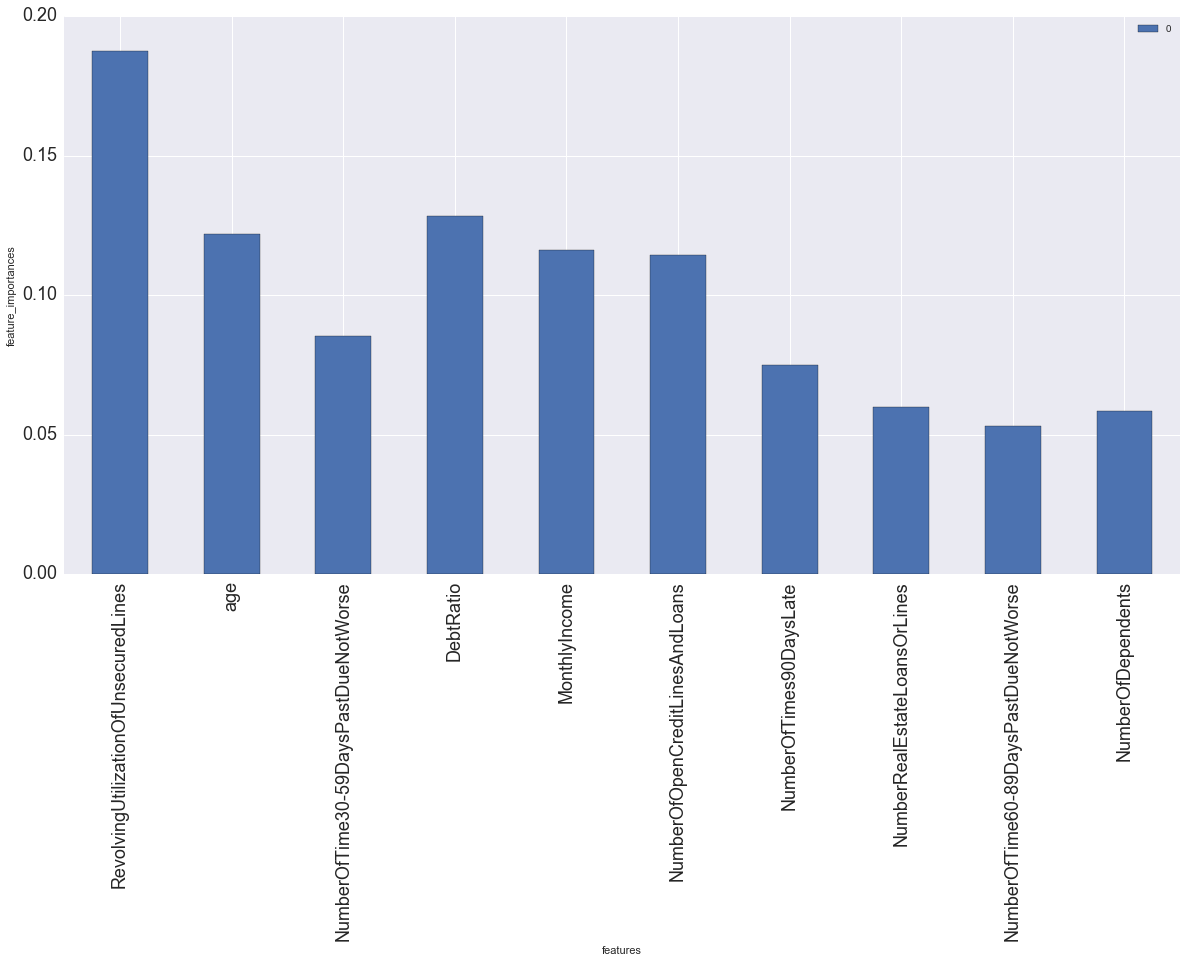

In [135]:
#  relative feature importances

X = cs_training[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
Y= np.array(cs_training['SeriousDlqin2yrs'])



clf = ExtraTreesClassifier()
clf = clf.fit(X, Y)
clf.feature_importances_ 

df_feature = pd.DataFrame(clf.feature_importances_ )
df_feature.index =[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
pd.DataFrame(df_feature).plot(kind='bar',figsize=(20, 10),fontsize=18) 
pyplot.xlabel('features')
pyplot.ylabel('feature_importances')

In [136]:
#clf = RF(n_estimators=10)




X = cs_training[['DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']]
Y= np.array(cs_training['SeriousDlqin2yrs'])

clf =RF(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.90000000000000002

In [137]:
confusion_matrix(clf.predict(X_test), y_test, labels=[1,0])

array([[  59,   64],
       [ 186, 2191]])

In [138]:
cm = confusion_matrix(y_test, clf.predict(X_test),labels=[1,0])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('\n Normalized confusion matrix \n')
print(cm_normalized)
plt.figure()
#plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')


 Normalized confusion matrix 

[[ 0.24081633  0.75918367]
 [ 0.02838137  0.97161863]]


ROC AUC: 0.74


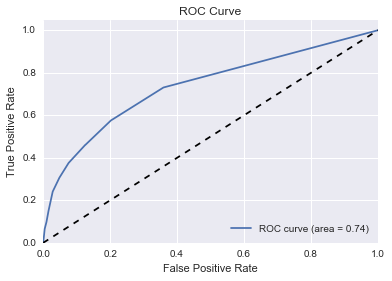

In [139]:
# ROC curve
# shuffle and split training and test sets
# Determine the false positive and true positive rates


fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# MODEL CREATING

# TEST DATA PREDICTION

In [140]:
cs_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              101503 non-null int64
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(7)
memory usage: 9.3 MB


In [141]:
# DATA CLEANING 
cs_test=cs_test.drop('SeriousDlqin2yrs', 1)
cs_test['MonthlyIncome'].fillna(cs_test['MonthlyIncome'].mean(),inplace=True)
cs_test['NumberOfDependents'].fillna(cs_test['NumberOfDependents'].mean(),inplace=True)


In [142]:
cs_test.columns=['Id', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [143]:
cs_test.head()

,Id,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [144]:
#cs_test_=pd.merge(cs_test,sampleEntry,on='Id')

In [145]:
#cs_test_.head()

In [146]:
#cs_test_=cs_test_.drop('SeriousDlqin2yrs', 1)
#cs_test_=cs_test_.dropna()
#cs_test_.head()

In [147]:
len(cs_test)

101503

In [148]:
sampleEntry.head()

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264


In [149]:
X2 = cs_test[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
#y2=cs_test['Probability']

In [150]:
cs_test.columns

Index(['Id', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [151]:
#clf.predict(X2)

In [152]:
clf.predict_proba(X2)

ValueError: Number of features of the model must  match the input. Model n_features is 5 and  input n_features is 10 

In [153]:
pd.DataFrame(clf.predict_proba(X2))

ValueError: Number of features of the model must  match the input. Model n_features is 5 and  input n_features is 10 

In [154]:
outcome=pd.DataFrame(clf.predict_proba(X2))

ValueError: Number of features of the model must  match the input. Model n_features is 5 and  input n_features is 10 

In [155]:
outcome_=pd.DataFrame({'id':outcome.index+1 , 'Probability':outcome[1]})#.to_csv('outcome.csv')
outcome_=outcome_[['id','Probability']]
outcome_.to_csv('outcome.csv')

In [156]:
outcome_#.columns

,id,Probability
0,1,0.1
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.3
5,6,0.0
6,7,0.1
7,8,0.1
8,9,0.0
9,10,0.5
